### Environment Set-up

In [6]:

# Spatial tools
!pip install shapely contextily

# For elevation if needed (LiDAR DTM)
!pip install rasterio

# For advanced modeling (optional)
!pip install xgboost

!pip install esda

In [53]:
# Core libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import os
import libpysal

# Geometry and spatial ops
from shapely.geometry import Point, Polygon
import contextily as cx
from shapely.geometry import box
from esda import Moran_Local

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as mpatches
from scipy.interpolate import griddata
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as mcolors


# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Warnings and display
import warnings
warnings.filterwarnings('ignore')



### Load Datasets

In [9]:
# egms folder
egms_csv_dir = "data/EGMS_CSV_Folder"

### Initial pre-process and view datasets

In [11]:

# Load and concatenate all CSV files
egms_df = pd.concat(
    [pd.read_csv(os.path.join(egms_csv_dir, f)) for f in os.listdir(egms_csv_dir)],
    ignore_index=True
)

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(egms_df['easting'], egms_df['northing'])]
egms_gdf = gpd.GeoDataFrame(egms_df, geometry=geometry, crs="EPSG:3035")

print("Total EGMS points loaded:", len(egms_gdf))
egms_gdf.head()

Total EGMS points loaded: 1993890


pid  easting  northing  height  rmse  mean_velocity   
0  40eFbfgZ3g  3400050   3300450   331.1   2.8            0.3  \
1  40eHQBeRjE  3400050   3302850   408.2   2.8            0.8   
2  40eLHHZweW  3400050   3307950   286.9   3.0           -1.0   
3  40eLa2EvQm  3400050   3308350   249.1   2.2            0.4   
4  40eLeiuAcq  3400050   3308450   251.6   2.6            0.4   

   mean_velocity_std  acceleration  acceleration_std  seasonality  ...   
0                0.1         -1.56              0.18          0.4  ...  \
1                0.1         -0.81              0.18          1.1  ...   
2                0.1          1.16              0.20          1.6  ...   
3                0.1          0.09              0.14          0.7  ...   
4                0.1          0.56              0.17          1.5  ...   

   20231031  20231106  20231112  20231118  20231124  20231130  20231206   
0       5.2       3.8       2.9       3.5       4.2       4.6       5.6  \
1       6.3       6.0       7.0       7.1       4.9       3.5       4.9   
2      -4.3      -4.5      -4.7       0.0       6.0       5.5       2.2   
3      -2.6      -2.5      -1.9       0.2       3.0       2.4      -0.9   
4      -7.0      -6.5      -6.9      -3.5       3.6       4.3      -1.0   

   20231212  20231218                  geometry  
0       5.4       4.0   POINT (3.4e+06 3.3e+06)  
1       6.3       6.6   POINT (3.4e+06 3.3e+06)  
2      -0.4      -2.1  POINT (3.4e+06 3.31e+06)  
3      -3.8      -5.8  POINT (3.4e+06 3.31e+06)  
4      -1.4       3.3  POINT (3.4e+06 3.31e+06)  

[5 rows x 313 columns]

In [12]:
cheshire = gpd.read_file("data/cheshire_boundaries_fixed.gpkg")
print("Rows:", len(cheshire))
display(cheshire.head())


Rows: 4


LAD24CD                    LAD24NM LAD24NMW   BNG_E   BNG_N     LONG   
0  E06000049              Cheshire East     None  380510  363462 -2.29300  \
1  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   
2  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   
3  E06000050  Cheshire West and Chester     None  353097  363145 -2.70298   

       LAT                              GlobalID   
0  53.1679  81091fd9-1548-48d7-a870-abf1cf45e9c3  \
1  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   
2  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   
3  53.1634  d5807502-f19f-45fa-a16d-889f5fd83a09   

                                            geometry  
0  MULTIPOLYGON (((3.7186e+05 3.8784e+05, 3.7186e...  
1  MULTIPOLYGON (((3.2787e+05 3.7372e+05, 3.2787e...  
2  MULTIPOLYGON (((3.2615e+05 3.7822e+05, 3.2614e...  
3  MULTIPOLYGON (((3.6715e+05 3.8292e+05, 3.6715e...

In [13]:

# Force set the known true CRS
cheshire = cheshire.set_crs(epsg=27700, allow_override=True)

# Now properly reproject to EPSG:3035
cheshire = cheshire.to_crs(epsg=3035)

# Check bounds
print("Cheshire bounds (now in EPSG:3035):", cheshire.total_bounds)


Cheshire bounds (now in EPSG:3035): [3451295.9280311  3387888.55515721 3525670.63616492 3435083.140797  ]


In [14]:
egms_cheshire = gpd.sjoin(egms_gdf, cheshire, how="inner", predicate="within")
print("Points in Cheshire:", len(egms_cheshire))
egms_cheshire.to_file("data/egms_points_in_cheshire.gpkg", driver="GPKG")

Points in Cheshire: 106336


#### Ensuring EGMS points are inside Cheshire boundary

In [16]:
import random

# If Cheshire has multiple polygons, unify them into one
cheshire_union = cheshire.dissolve()

# Sample 5 random points from the clipped EGMS
for i in range(5):
    sample = egms_cheshire.sample(1)
    pt = sample.geometry.iloc[0]
    # Check if the point is within the dissolved polygon
    is_inside = pt.within(cheshire_union.geometry.iloc[0])
    print(f"Sample point {pt}: Is inside Cheshire? {is_inside}")


Sample point POINT (3456050 3430750): Is inside Cheshire? True
Sample point POINT (3489750 3399750): Is inside Cheshire? True
Sample point POINT (3503850 3425950): Is inside Cheshire? True
Sample point POINT (3502950 3401250): Is inside Cheshire? True
Sample point POINT (3510550 3423750): Is inside Cheshire? True


In [17]:
print("Clipped EGMS Bounds:", egms_cheshire.total_bounds)
print("Cheshire Bounds:", cheshire.total_bounds)


Clipped EGMS Bounds: [3453750. 3388250. 3525650. 3434750.]
Cheshire Bounds: [3451295.9280311  3387888.55515721 3525670.63616492 3435083.140797  ]


### Descriptive Summary of EGMS Points in Cheshire

In [55]:

# 2. Dataset shape and basic info

print("Dataset Overview")
print(f" - Total rows: {len(egms_cheshire)}")
print(f" - Total columns: {egms_cheshire.shape[1]}")
print(f" - CRS: {egms_cheshire.crs}")
print(f" - Geometry type: {egms_cheshire.geom_type.unique()}")
print(f" - Bounding box: {egms_cheshire.total_bounds}")

# -------------------------------
# 3. Summary of numeric columns
# -------------------------------
numeric_cols = egms_cheshire.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_summary = egms_cheshire[numeric_cols].describe().T
numeric_summary["missing_count"] = egms_cheshire[numeric_cols].isna().sum()
numeric_summary["missing_%"] = 100 * numeric_summary["missing_count"] / len(egms_cheshire)

print("\nSummary of Numeric Columns:")
print(numeric_summary[["count", "mean", "std", "min", "max", "missing_count", "missing_%"]].round(2))

# -------------------------------
# 4. Summary of categorical/object columns
# -------------------------------
cat_cols = egms_cheshire.select_dtypes(include=["object"]).columns.tolist()
print("\nSummary of Categorical Columns:")
for col in cat_cols:
    unique_vals = egms_cheshire[col].nunique()
    sample_vals = egms_cheshire[col].dropna().unique()[:5]
    print(f" - {col}: {unique_vals} unique values. Sample: {sample_vals}")

# -------------------------------
# 5. Geometry column overview
# -------------------------------
print("\nGeometry Summary:")
print(f" - Geometry column: {egms_cheshire.geometry.name}")
print(f" - Geometry types: {egms_cheshire.geom_type.value_counts().to_dict()}")


Dataset Overview
 - Total rows: 106336
 - Total columns: 326
 - CRS: EPSG:3035
 - Geometry type: ['Point']
 - Bounding box: [3453750. 3388250. 3525650. 3434750.]

Summary of Numeric Columns:
                      count        mean       std         min         max   
easting            106336.0  3489485.77  17868.29  3453750.00  3525650.00  \
northing           106336.0  3416163.89  10179.87  3388250.00  3434750.00   
height             106336.0       72.82     65.21       -2.90      543.00   
rmse               106336.0        1.37      0.87        0.30        5.70   
mean_velocity      106336.0       -0.59      0.91      -16.30       11.80   
...                     ...         ...       ...         ...         ...   
LONG               106336.0       -2.48      0.20       -2.70       -2.29   
LAT                106336.0       53.17      0.00       53.16       53.17   
trend_mm_per_yr    106336.0       -0.59      0.92      -16.41       11.61   
lisa_cluster       106336.0        2.43

In [74]:
egms_cheshire.head()

# Quick overview of numeric columns
egms_cheshire[['mean_velocity', 'acceleration', 'rmse']].describe()
egms_cheshire[['mean_velocity', 'acceleration', 'rmse']].skew()
egms_cheshire[['mean_velocity', 'acceleration', 'rmse']].kurt()


mean_velocity    18.315125
acceleration      7.662015
rmse              1.055352
dtype: float64

### EDA of EGMS data Inside Cheshire Boundary

Descriptive Statistics for Ground Motion Trend (mm/year):
count   106336.00
mean        -0.59
std          0.92
min        -16.41
25%         -1.02
50%         -0.59
75%         -0.11
max         11.61

 Outlier Summary
 - IQR: 0.91
 - Lower threshold: -2.38
 - Upper threshold: 1.25
 - Outliers detected: 4538
   (That’s 4.3% of all valid points)


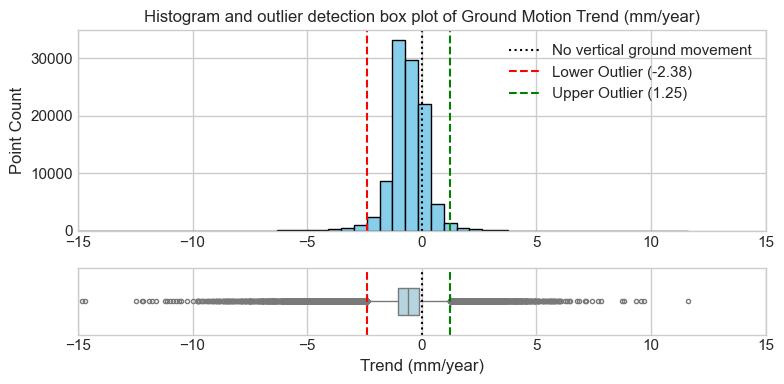

In [101]:

date_cols = sorted([col for col in egms_cheshire.columns if col.isdigit()])
dt_index = pd.to_datetime(date_cols, format="%Y%m%d")
t = (dt_index - dt_index.min()) / np.timedelta64(1, "Y")

# Compute ground motion trend

def compute_trend(row):
    y = row[date_cols].astype(float).values
    mask = ~np.isnan(y)
    if mask.sum() < 2:
        return np.nan
    slope, _ = np.polyfit(t[mask], y[mask], 1)
    return slope

egms_cheshire["trend_mm_per_yr"] = egms_cheshire.apply(compute_trend, axis=1)


#  Descriptive statistics of Trend Calculated above

trend_series = egms_cheshire["trend_mm_per_yr"]
desc = trend_series.describe()

print("Descriptive Statistics for Ground Motion Trend (mm/year):")
print(desc.to_string(float_format="%.2f"))


#  Outlier detection using IQR # Compute IQR and outlier thresholds

q1, q3 = desc["25%"], desc["75%"]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = trend_series[(trend_series < lower_bound) | (trend_series > upper_bound)]

#  Outlier summary
print("\n Outlier Summary")
print(f" - IQR: {iqr:.2f}")
print(f" - Lower threshold: {lower_bound:.2f}")
print(f" - Upper threshold: {upper_bound:.2f}")
print(f" - Outliers detected: {len(outliers)}")
print(f"   (That’s {len(outliers)/len(trend_series)*100:.1f}% of all valid points)")

# Create combined figure
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 1]})

# Histogram (top plot)
ax[0].hist(trend_series, bins=50, color='skyblue', edgecolor='black')
ax[0].axvline(x=0, color='black', linestyle=':', label='No vertical ground movement')
ax[0].axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Outlier ({lower_bound:.2f})')
ax[0].axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Outlier ({upper_bound:.2f})')
ax[0].set_xlim(-15, 15)
ax[0].set_title("Histogram and outlier detection box plot of Ground Motion Trend (mm/year)")
ax[0].set_ylabel("Point Count")
ax[0].legend(loc='upper right')

# Boxplot (bottom plot)
sns.boxplot(x=trend_series, ax=ax[1], color='lightblue', width=0.4, fliersize=3)
ax[1].axvline(x=0, color='black', linestyle=':')
ax[1].axvline(x=lower_bound, color='red', linestyle='--')
ax[1].axvline(x=upper_bound, color='green', linestyle='--')
ax[1].set_xlim(-15, 15)
ax[1].set_xlabel("Trend (mm/year)")
ax[1].set_yticks([])

# Final layout
plt.tight_layout()
plt.show()

#### Visualizing the distribution of key ground motion metrics: Mean Velocity and Acceleration

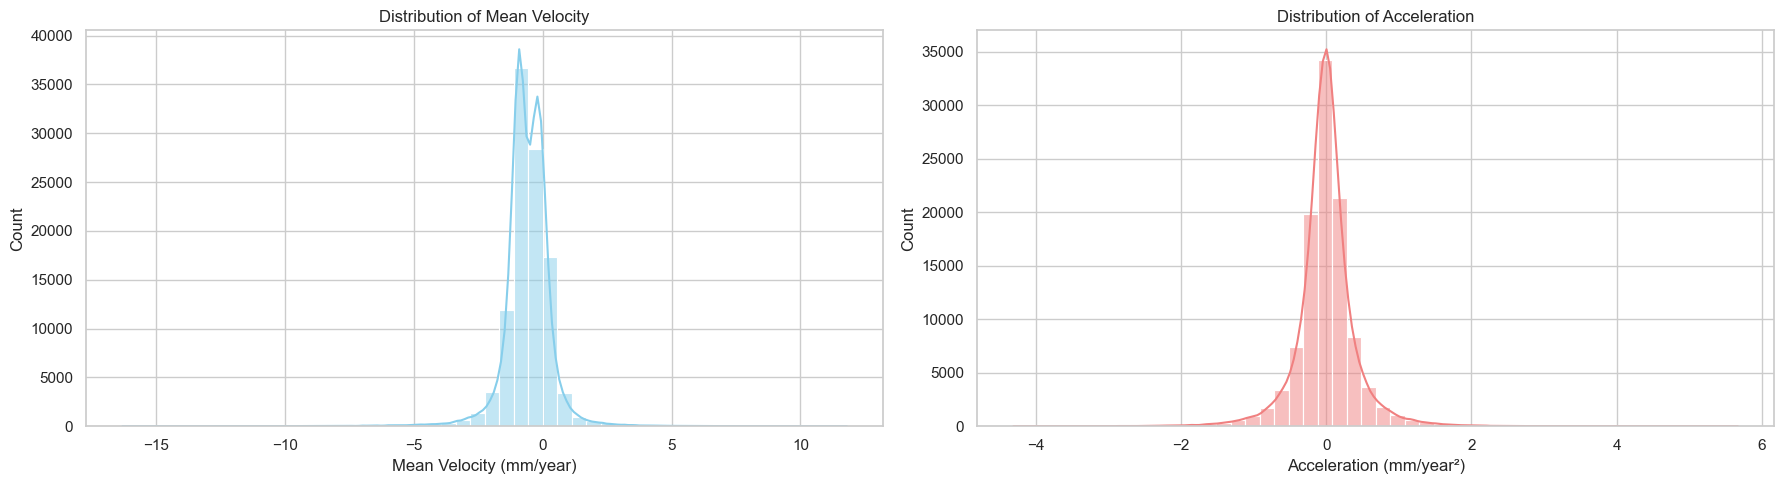

In [79]:

# Set style
sns.set(style="whitegrid")

# Create subplots for each distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Mean velocity
sns.histplot(egms_cheshire['mean_velocity'], bins=50, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title("Distribution of Mean Velocity")
axs[0].set_xlabel("Mean Velocity (mm/year)")

# Acceleration
sns.histplot(egms_cheshire['acceleration'], bins=50, kde=True, ax=axs[1], color='lightcoral')
axs[1].set_title("Distribution of Acceleration")
axs[1].set_xlabel("Acceleration (mm/year²)")

plt.tight_layout()
plt.show()


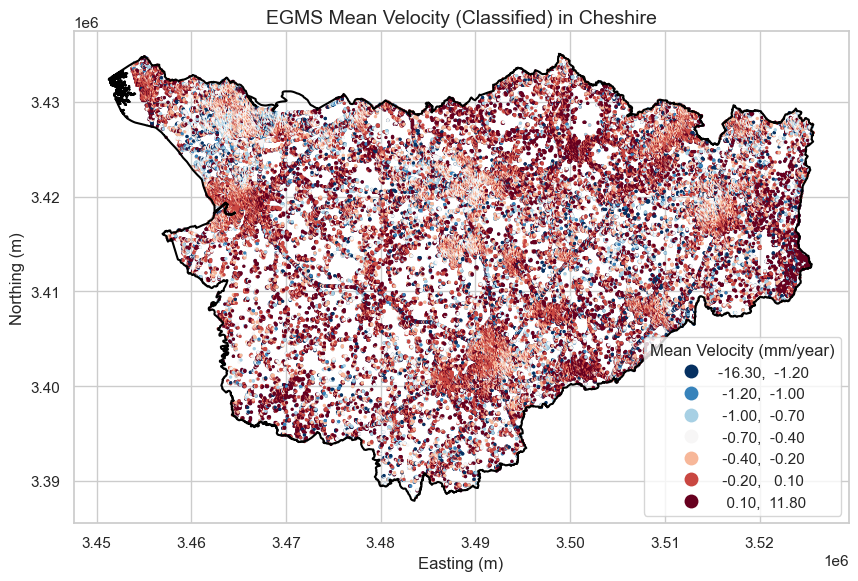

In [80]:
#Visualise Mean velocity for each point spatially

fig, ax = plt.subplots(figsize=(10, 8))

egms_cheshire.plot(
    ax=ax,
    column='mean_velocity',
    cmap='RdBu_r',           # diverging colormap: red=negative, blue=positive
    scheme='quantiles',      # splits data into quantile-based classes
    k=7,                     # number of classes
    legend=True,
    legend_kwds={
        'title': "Mean Velocity (mm/year)"
    },
    markersize=2
)

# Plot Cheshire boundary (dissolved)
cheshire_union = cheshire.dissolve()
cheshire_union.boundary.plot(ax=ax, color='black', linewidth=1.5)

ax.set_title("EGMS Mean Velocity (Classified) in Cheshire", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.show()


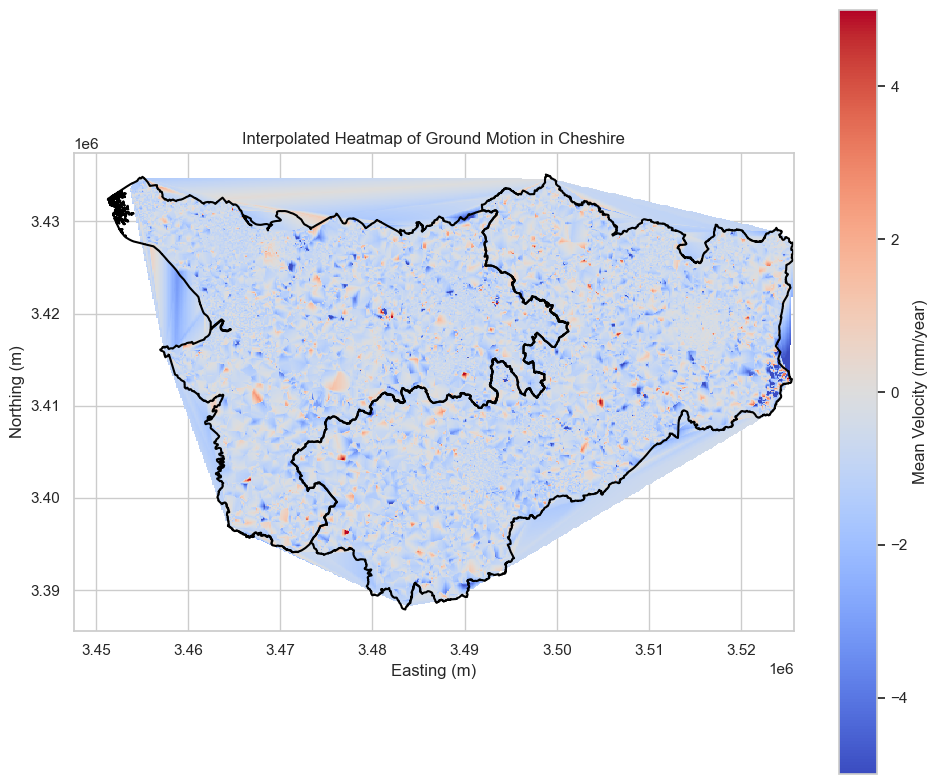

In [26]:

# Grid resolution
res = 500j

# Create grid for interpolation
grid_x, grid_y = np.mgrid[
    egms_cheshire.total_bounds[0]:egms_cheshire.total_bounds[2]:res,
    egms_cheshire.total_bounds[1]:egms_cheshire.total_bounds[3]:res
]
points = np.vstack((egms_cheshire.geometry.x, egms_cheshire.geometry.y)).T
values = egms_cheshire['mean_velocity']

# Interpolate
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Mask out nan values
masked_z = ma.masked_invalid(grid_z)

# Define figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create a normalization centered at 0
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# Plot heatmap
heatmap = ax.pcolormesh(grid_x, grid_y, masked_z, cmap='coolwarm', norm=norm, shading='auto')

# Clip heatmap to Cheshire boundary
cheshire.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Add colorbar and title
cbar = plt.colorbar(heatmap, ax=ax, label='Mean Velocity (mm/year)')
plt.title("Interpolated Heatmap of Ground Motion in Cheshire")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.tight_layout()
plt.show()


### Check Spatial Auto-correlation

In [28]:
from esda.moran import Moran
from libpysal.weights import KNN

# Create spatial weights (e.g., k-nearest neighbors)
w = KNN.from_dataframe(egms_gdf, k=8)
w.transform = 'R'

# Calculate Moran’s I for vertical velocity 
moran = Moran(egms_gdf["mean_velocity"], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


Moran's I: 0.16839135924238535, p-value: 0.001


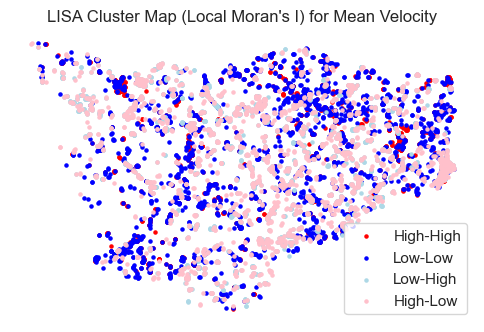

In [49]:
# Required libraries


# Step 1: Spatial weights matrix using Queen contiguity or KNN (if points)
# For point data like EGMS, KNN is usually preferred
w = libpysal.weights.KNN.from_dataframe(egms_cheshire, k=8)
w.transform = 'r'

# Step 2: Calculate Local Moran's I for mean_velocity
lisa = Moran_Local(egms_cheshire['mean_velocity'], w)

# Step 3: Add LISA results to your GeoDataFrame
egms_cheshire['lisa_cluster'] = lisa.q  # cluster category (1-4)
egms_cheshire['lisa_significance'] = lisa.p_sim  # p-values

# Step 4: Define cluster labels for interpretation
cluster_labels = {
    1: 'High-High',   # Substantial subsidence surrounded by similar
    2: 'Low-Low',     # Stable areas surrounded by stable points
    3: 'Low-High',    # Spatial outlier
    4: 'High-Low'     # Spatial outlier
}
egms_cheshire['lisa_type'] = egms_cheshire['lisa_cluster'].map(cluster_labels)

# Optional: filter significant clusters at 95% confidence
significant = egms_cheshire['lisa_significance'] < 0.05
egms_cheshire_sig = egms_cheshire[significant]

# Step 5: Plotting the LISA cluster map
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

color_map = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'Low-High': 'lightblue',
    'High-Low': 'pink'
}

for label, color in color_map.items():
    egms_cheshire_sig[egms_cheshire_sig['lisa_type'] == label].plot(
        ax=ax, color=color, markersize=5, label=label)

egms_cheshire.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.legend()
ax.set_title('LISA Cluster Map (Local Moran\'s I) for Mean Velocity', fontsize=12)
ax.axis('off')
plt.show()


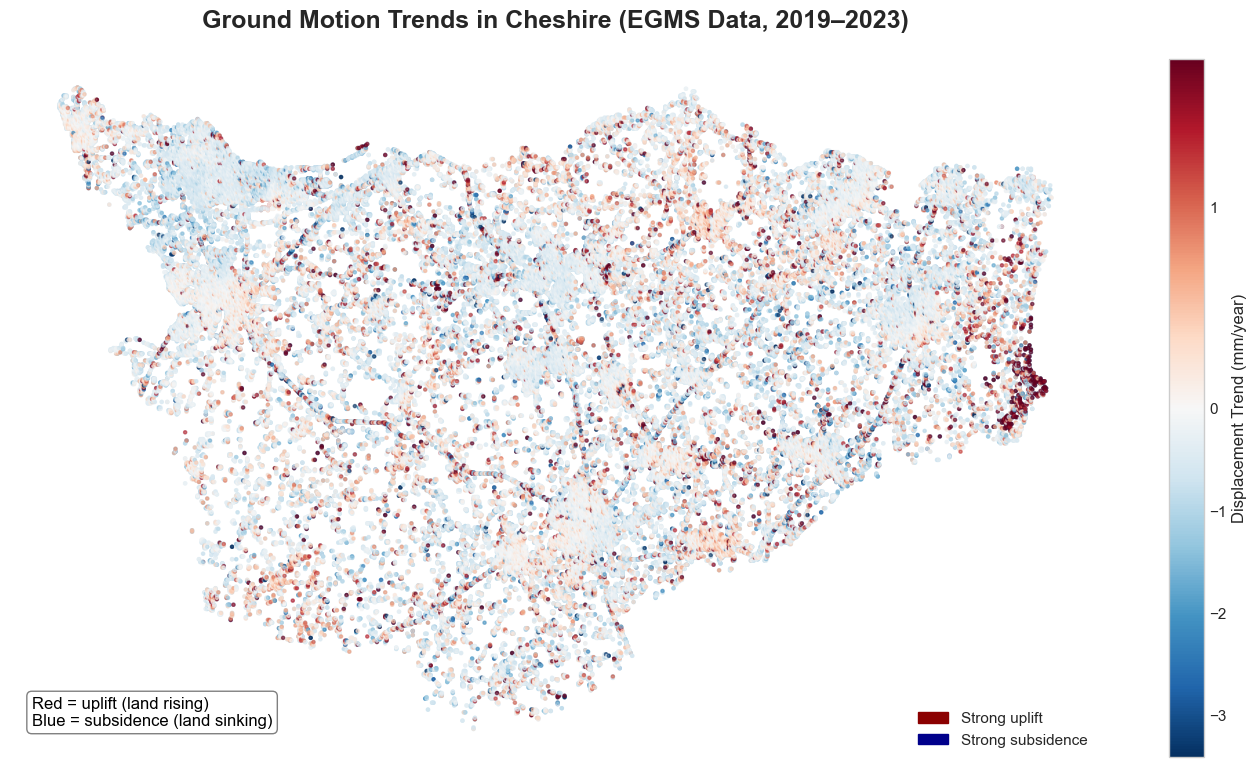

In [112]:
gdf_valid = egms_cheshire.dropna(subset=["trend_mm_per_yr"])

# Create a diverging normalization centered at 0
vmin = np.nanpercentile(gdf_valid["trend_mm_per_yr"], 1)
vmax = np.nanpercentile(gdf_valid["trend_mm_per_yr"], 99)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plotting
fig, ax = plt.subplots(figsize=(14, 12))

sc = gdf_valid.plot(
    column="trend_mm_per_yr",
    cmap="RdBu_r",
    norm=norm,
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Displacement Trend (mm/year)",
        "shrink": 0.6,
        "orientation": "vertical"
    },
    markersize=5,
    alpha=0.6
)

#  Add annotations
ax.set_title(
    "Ground Motion Trends in Cheshire (EGMS Data, 2019–2023)",
    fontsize=18, fontweight='bold', pad=20
)
ax.annotate(
    "Red = uplift (land rising)\nBlue = subsidence (land sinking)",
    xy=(0.02, 0.05), xycoords='axes fraction',
    fontsize=12, color="black",
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
ax.set_axis_off()

# Add scale indicator patches (custom legend)
uplift_patch = mpatches.Patch(color='darkred', label='Strong uplift')
subsidence_patch = mpatches.Patch(color='darkblue', label='Strong subsidence')
ax.legend(handles=[uplift_patch, subsidence_patch], loc='lower right')

# Display
plt.tight_layout()
plt.show()


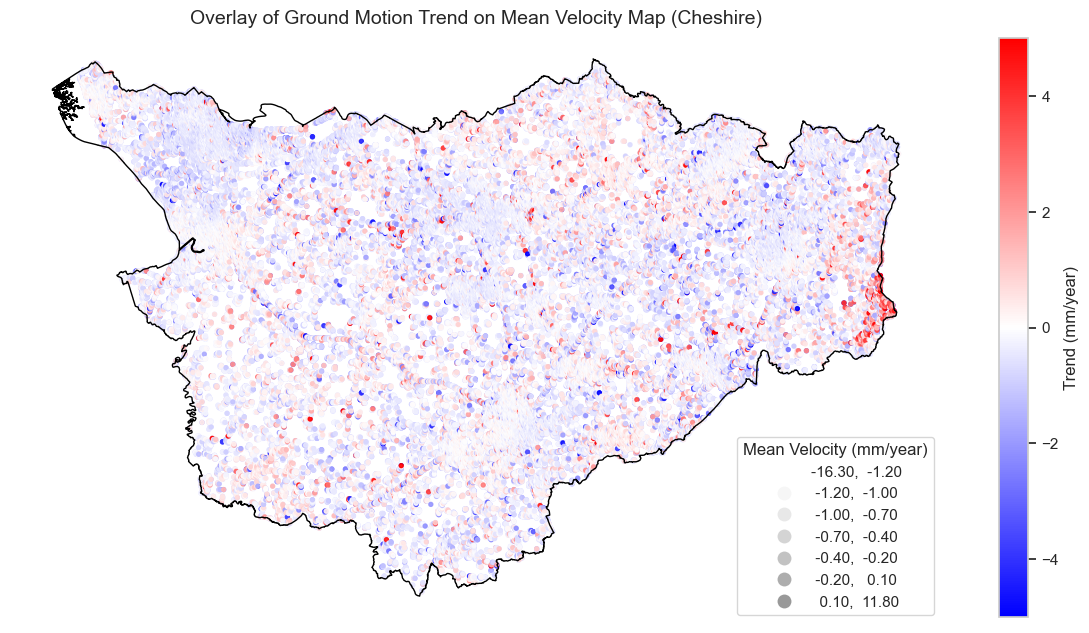

In [60]:

# Plot base map (Mean Velocity) in grayscale for minimal distraction
fig, ax = plt.subplots(figsize=(12, 10))

# Use a muted grayscale colormap for the base layer
egms_cheshire.plot(
    ax=ax,
    column='mean_velocity',
    cmap='Greys',
    scheme='quantiles',
    k=7,
    legend=True,
    legend_kwds={'title': "Mean Velocity (mm/year)"},
    markersize=2,
    alpha=0.4
)

# Overlay Trend with HIGH contrast (e.g., bright red/blue)

from matplotlib.colors import TwoSlopeNorm
trend_norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

gdf_valid.plot(
    ax=ax,
    column='trend_mm_per_yr',
    cmap='bwr',  # Blue-white-red for contrast
    norm=trend_norm,
    markersize=8,
    legend=True,
    legend_kwds={'label': "Trend (mm/year)", 'shrink': 0.6},
    alpha=0.9
)

# Step 3: Add boundary for context
cheshire_union.boundary.plot(ax=ax, color='black', linewidth=1)

# Step 4: Final presentation
ax.set_title("Overlay of Ground Motion Trend on Mean Velocity Map (Cheshire)", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [84]:
date_index = pd.to_datetime(date_cols, format="%Y%m%d")

# Mean displacement (Series)
monthly_displacement = egms_cheshire[date_cols].mean()

monthly_displacement.index = date_index
monthly_mean = monthly_displacement.resample('M').mean()

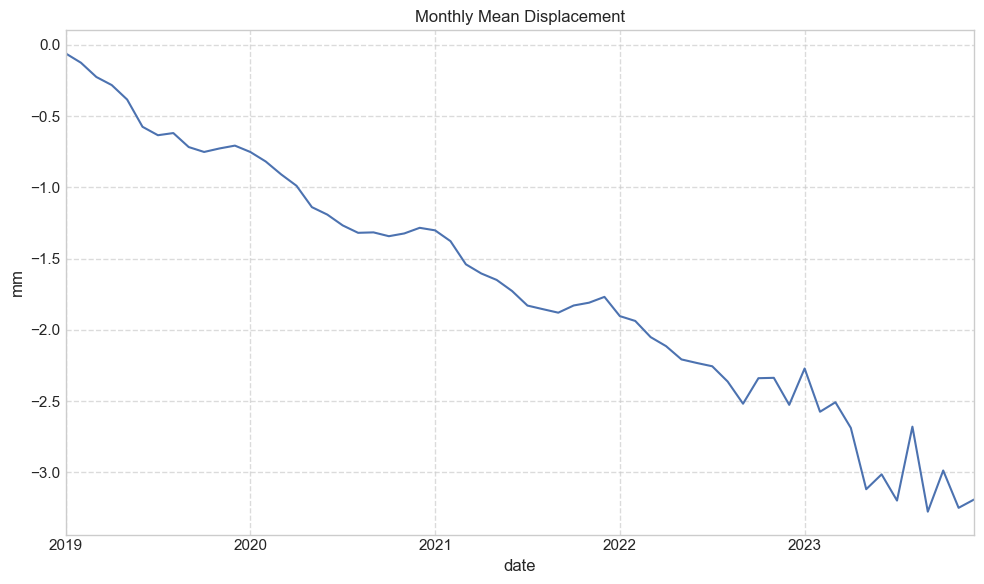

In [86]:

warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use('seaborn-v0_8-whitegrid')
monthly_mean.plot(title='Monthly Mean Displacement', ylabel='mm', xlabel='date', figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Data Quality Checks
* LiDAR data or satellite-based surface displacement data like EGMS inherently contain errors due to factors such as sensor accuracy, terrain conditions, and climate influences. These errors are often represented by the Root Mean Square Error (RMSE) value, which is used to assess the quality or reliability of interpolation.

Text(0, 0.5, 'Number of Points')

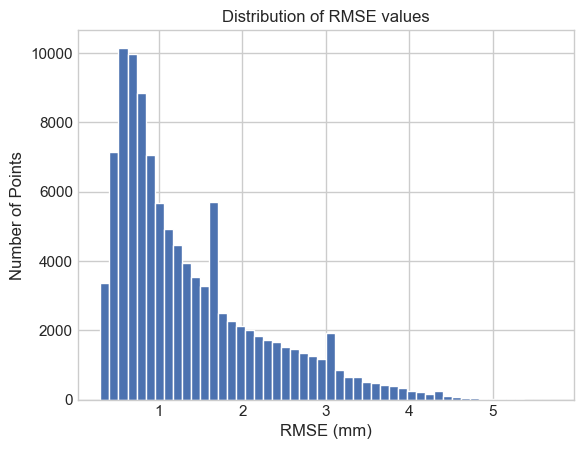

In [32]:
egms_cheshire['rmse'].hist(bins=50)
plt.title('Distribution of RMSE values')
plt.xlabel('RMSE (mm)')
plt.ylabel('Number of Points')

In [33]:
# If there are many locations where the RMSE is 5 or higher, it implies that there are many areas with lower data quality. -> Not many!

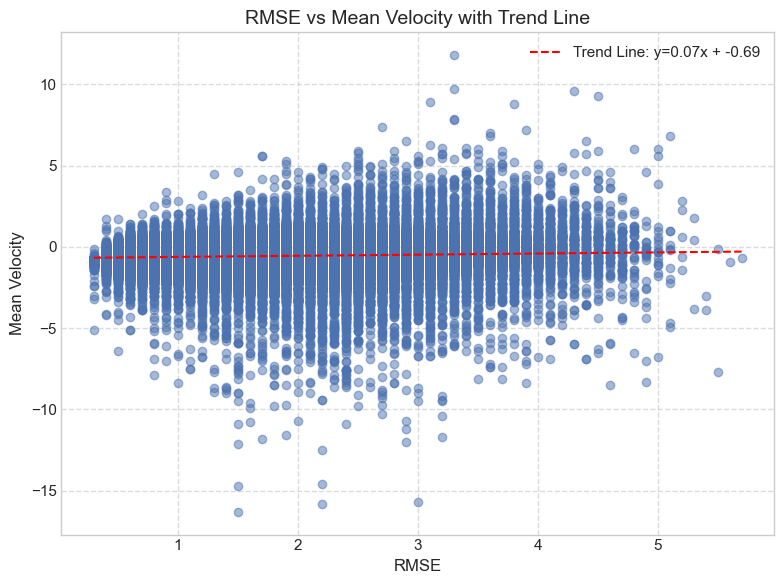

In [34]:

rmse = egms_cheshire['rmse']
mean_velocity = egms_cheshire['mean_velocity']

coefficients = np.polyfit(rmse, mean_velocity, 1)
polynomial = np.poly1d(coefficients)
rmse_sorted = np.sort(rmse)

plt.figure(figsize=(8, 6))
plt.scatter(rmse, mean_velocity, alpha=0.5)
plt.plot(rmse_sorted, polynomial(rmse_sorted), color='red', linestyle='--', label=f'Trend Line: y={coefficients[0]:.2f}x + {coefficients[1]:.2f}')

plt.title('RMSE vs Mean Velocity with Trend Line', fontsize=14)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Mean Velocity', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

If the mean velocity is significantly high in areas with high RMSE (Root Mean Square Error), it could indicate a potential error.
<br><br>
RMSE vs Mean Velocity Relationshop
: Spots generally distributed widely and evenly
-> No significant correaltion
<br><br>
: Tilt of the regression line is almost horizon (low positive correlation)
-> interpolation X

         Type HS2_Phase                   HS2_DocNum HS2_DocRev HS2_RevDat   
0  Embankment        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24  \
1     Viaduct        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
2     Cutting        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
3    At Grade        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   
4     Viaduct        R2  2RS02-WSP-GI-GDD-000-000011        P02 2018-10-24   

  Currency Baseline HS2_ValidF HS2_ValidT  OBJECTID  Shape__Len   
0     None     WDES 2018-10-10       None         1  669.999942  \
1     None     WDES 2018-10-10       None         2  584.000006   
2     None     WDES 2018-10-10       None         3  916.999896   
3     None     WDES 2018-10-10       None         4  109.999966   
4     None     WDES 2018-10-10       None         5  213.000005   

                                            geometry  
0  LINESTRING Z (4.47e+05 3.55e+05 118, 4.47e+05 ...  
1  LINESTRING Z (4

<Axes: >

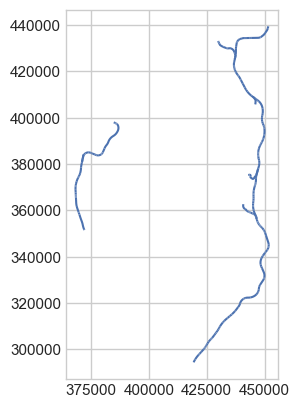

In [36]:
shapefile_path = "data/HS2_Route_Detailed.shp"
gdf = gpd.read_file(shapefile_path)

print(gdf.head())
gdf.plot()

In [37]:
print("Cheshire CRS:", cheshire.crs)
print("GDF CRS:", gdf.crs)


Cheshire CRS: EPSG:3035
GDF CRS: EPSG:27700


In [38]:
if cheshire.crs != gdf.crs:
    gdf = gdf.to_crs(cheshire.crs)

gdf_filtered = gdf[gdf.geometry.intersects(cheshire.unary_union)]
print(f"Filtered features: {len(gdf_filtered)}")

Filtered features: 65


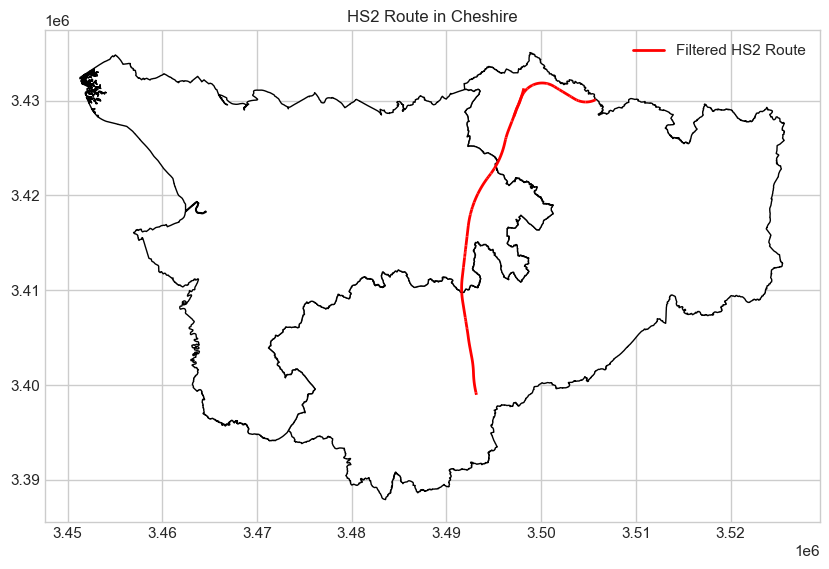

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')

gdf_filtered = gdf[gdf.geometry.within(cheshire.unary_union)]
gdf_filtered.plot(ax=ax, color='red', linewidth=2)

# Add a proxy artist for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Filtered HS2 Route')]
ax.legend(handles=legend_elements)

plt.title("HS2 Route in Cheshire")
plt.show()

## Groundwater data inspection

* https://www.bgs.ac.uk/datasets/hydrogeology-625k/#download

   OBJECTID        ROCK_UNIT CLASS                              CHARACTER   
0       1.0  GAULT FORMATION     3  Rocks with essentially no groundwater  \
1       2.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
2       3.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
3       4.0  GAULT FORMATION     3  Rocks with essentially no groundwater   
4       5.0  GAULT FORMATION     3  Rocks with essentially no groundwater   

  FLOW_MECHA                                            SUMMARY   
0       None  Low permeability clays up to 100 m thick separ...  \
1       None  Low permeability clays up to 100 m thick separ...   
2       None  Low permeability clays up to 100 m thick separ...   
3       None  Low permeability clays up to 100 m thick separ...   
4       None  Low permeability clays up to 100 m thick separ...   

                 VERSION                                           geometry  
0  HydrogeologyUK_IoM_v5  POLYGON ((3.76e+05 1.36e+05, 3

<Axes: >

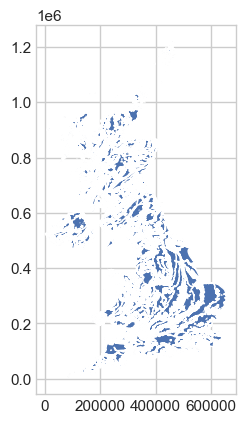

In [41]:
shapefile_path = "Data/HydrogeologyUK_IoM_v5.shp"
gwdf = gpd.read_file(shapefile_path)

print(gwdf.head())
gwdf.plot()

In [42]:
gwdf

OBJECTID                  ROCK_UNIT CLASS   
0           1.0            GAULT FORMATION     3  \
1           2.0            GAULT FORMATION     3   
2           3.0            GAULT FORMATION     3   
3           4.0            GAULT FORMATION     3   
4           5.0            GAULT FORMATION     3   
...         ...                        ...   ...   
13777   13780.0        GREY CHALK SUBGROUP    2A   
13778   13781.0       FELL SANDSTONE GROUP    1B   
13779   13782.0  UPPER GREENSAND FORMATION    1B   
13780   13783.0  UPPER GREENSAND FORMATION    1B   
13781       0.0               ARGYLL GROUP    2C   

                                   CHARACTER   
0      Rocks with essentially no groundwater  \
1      Rocks with essentially no groundwater   
2      Rocks with essentially no groundwater   
3      Rocks with essentially no groundwater   
4      Rocks with essentially no groundwater   
...                                      ...   
13777              Highly productive aquifer   
13778          Moderately productive aquifer   
13779          Moderately productive aquifer   
13780          Moderately productive aquifer   
13781               Low productivity aquifer   

                                              FLOW_MECHA   
0                                                   None  \
1                                                   None   
2                                                   None   
3                                                   None   
4                                                   None   
...                                                  ...   
13777  Flow is virtually all through fractures and ot...   
13778                     Significant intergranular flow   
13779                     Significant intergranular flow   
13780                     Significant intergranular flow   
13781  Flow is virtually all through fractures and ot...   

                                                 SUMMARY   
0      Low permeability clays up to 100 m thick separ...  \
1      Low permeability clays up to 100 m thick separ...   
2      Low permeability clays up to 100 m thick separ...   
3      Low permeability clays up to 100 m thick separ...   
4      Low permeability clays up to 100 m thick separ...   
...                                                  ...   
13777  Marly Chalk aquifer that can yield up to 5 L/s...   
13778  Locally important aquifer up to 300 m thick wi...   
13779  Glauconitic sands yielding up to 25 L/s and of...   
13780  Glauconitic sands yielding up to 25 L/s and of...   
13781  Small amounts of groundwater in near surface w...   

                     VERSION   
0      HydrogeologyUK_IoM_v5  \
1      HydrogeologyUK_IoM_v5   
2      HydrogeologyUK_IoM_v5   
3      HydrogeologyUK_IoM_v5   
4      HydrogeologyUK_IoM_v5   
...                      ...   
13777  HydrogeologyUK_IoM_v5   
13778  HydrogeologyUK_IoM_v5   
13779  HydrogeologyUK_IoM_v5   
13780  HydrogeologyUK_IoM_v5   
13781  HydrogeologyUK_IoM_v5   

                                                geometry  
0      POLYGON ((3.76e+05 1.36e+05, 3.76e+05 1.37e+05...  
1      POLYGON ((3.75e+05 1.37e+05, 3.75e+05 1.37e+05...  
2      POLYGON ((3.76e+05 1.38e+05, 3.76e+05 1.38e+05...  
3      POLYGON ((3.77e+05 1.38e+05, 3.76e+05 1.38e+05...  
4      POLYGON ((3.8e+05 1.41e+05, 3.8e+05 1.41e+05, ...  
...                                                  ...  
13777  POLYGON ((5.32e+05 1.53e+05, 5.32e+05 1.53e+05...  
13778  POLYGON ((3.99e+05 6.53e+05, 3.99e+05 6.53e+05...  
13779  POLYGON ((3.3e+05 1.05e+05, 3.3e+05 1.05e+05, ...  
13780  POLYGON ((3.3e+05 1.05e+05, 3.3e+05 1.06e+05, ...  
13781  POLYGON ((8.72e+04 5.65e+05, 8.73e+04 5.65e+05...  

[13782 rows x 8 columns]

In [43]:
gwdf['CHARACTER'].unique()

array(['Rocks with essentially no groundwater',
       'Moderately productive aquifer', 'Low productivity aquifer',
       'Highly productive aquifer', 'Low productive aquifer'],
      dtype=object)

In [44]:
gwdf['FLOW_MECHA'].unique()

array([None, 'Significant intergranular flow',
       'Flow is virtually all through fractures and other discontinuities'],
      dtype=object)

In [45]:
if cheshire.crs != gwdf.crs:
    gwdf = gwdf.to_crs(cheshire.crs)

gwdf_filtered = gwdf[gwdf.geometry.intersects(cheshire.unary_union)]
print(f"Filtered features: {len(gwdf_filtered)}")

Filtered features: 38


In [46]:
gwdf_filtered.head()

OBJECTID                           ROCK_UNIT CLASS   
1092    1093.0    PERMIAN ROCKS (UNDIFFERENTIATED)    1A  \
1875    1876.0  DINANTIAN ROCKS (UNDIFFERENTIATED)    2B   
3341    3342.0                MILLSTONE GRIT GROUP    2B   
3907    3908.0   TRIASSIC ROCKS (UNDIFFERENTIATED)    1A   
4228    4229.0                          LIAS GROUP     3   

                                  CHARACTER   
1092              Highly productive aquifer  \
1875          Moderately productive aquifer   
3341          Moderately productive aquifer   
3907              Highly productive aquifer   
4228  Rocks with essentially no groundwater   

                                             FLOW_MECHA   
1092                     Significant intergranular flow  \
1875  Flow is virtually all through fractures and ot...   
3341  Flow is virtually all through fractures and ot...   
3907                     Significant intergranular flow   
4228                                               None   

                                                SUMMARY   
1092  Sandstone, with some conglomerates, aquifer yi...  \
1875  Massive karstic limestone aquifer with rapid r...   
3341  Regionally significant multi-layered aquifer u...   
3907  Principal sandstone aquifer up to 600 m thick ...   
4228  Largely mudstone sequence with limestone and M...   

                    VERSION                                           geometry  
1092  HydrogeologyUK_IoM_v5  POLYGON ((3.46e+06 3.43e+06, 3.46e+06 3.43e+06...  
1875  HydrogeologyUK_IoM_v5  POLYGON ((3.51e+06 3.4e+06, 3.51e+06 3.4e+06, ...  
3341  HydrogeologyUK_IoM_v5  POLYGON ((3.52e+06 3.43e+06, 3.52e+06 3.43e+06...  
3907  HydrogeologyUK_IoM_v5  POLYGON ((3.52e+06 3.41e+06, 3.52e+06 3.41e+06...  
4228  HydrogeologyUK_IoM_v5  POLYGON ((3.48e+06 3.4e+06, 3.48e+06 3.4e+06, ...

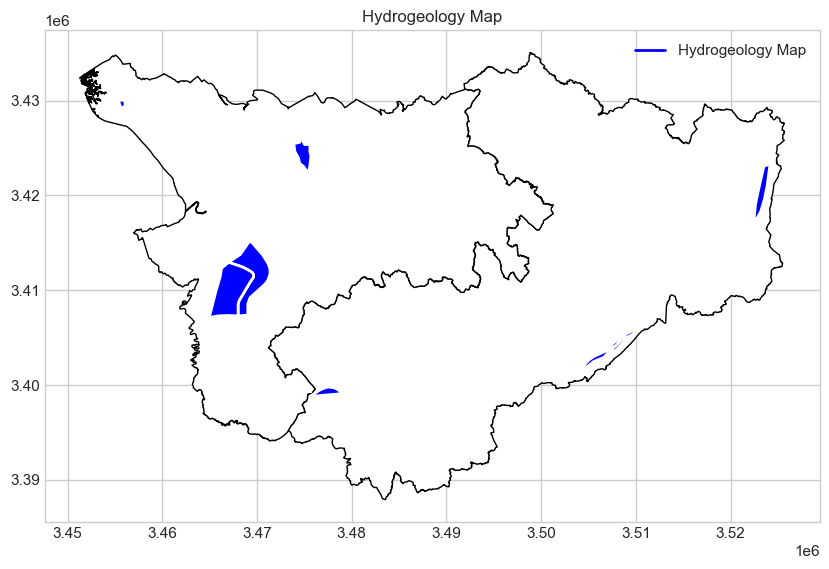

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')

gwdf_filtered = gwdf[gwdf.geometry.within(cheshire.unary_union)]
gwdf_filtered.plot(ax=ax, color='blue', linewidth=2)

# Add a proxy artist for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Hydrogeology Map')]
ax.legend(handles=legend_elements)

plt.title("Hydrogeology Map")
plt.show()

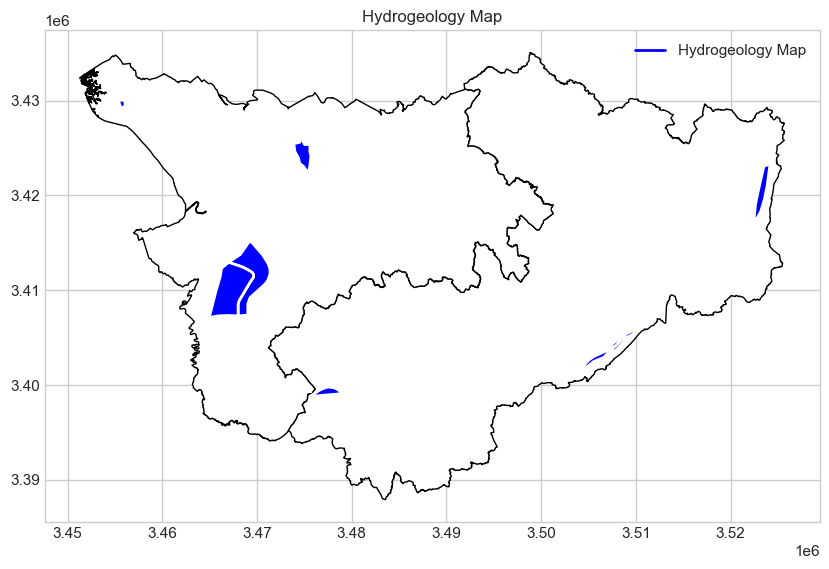

Number of unique CHARACTER values: 4


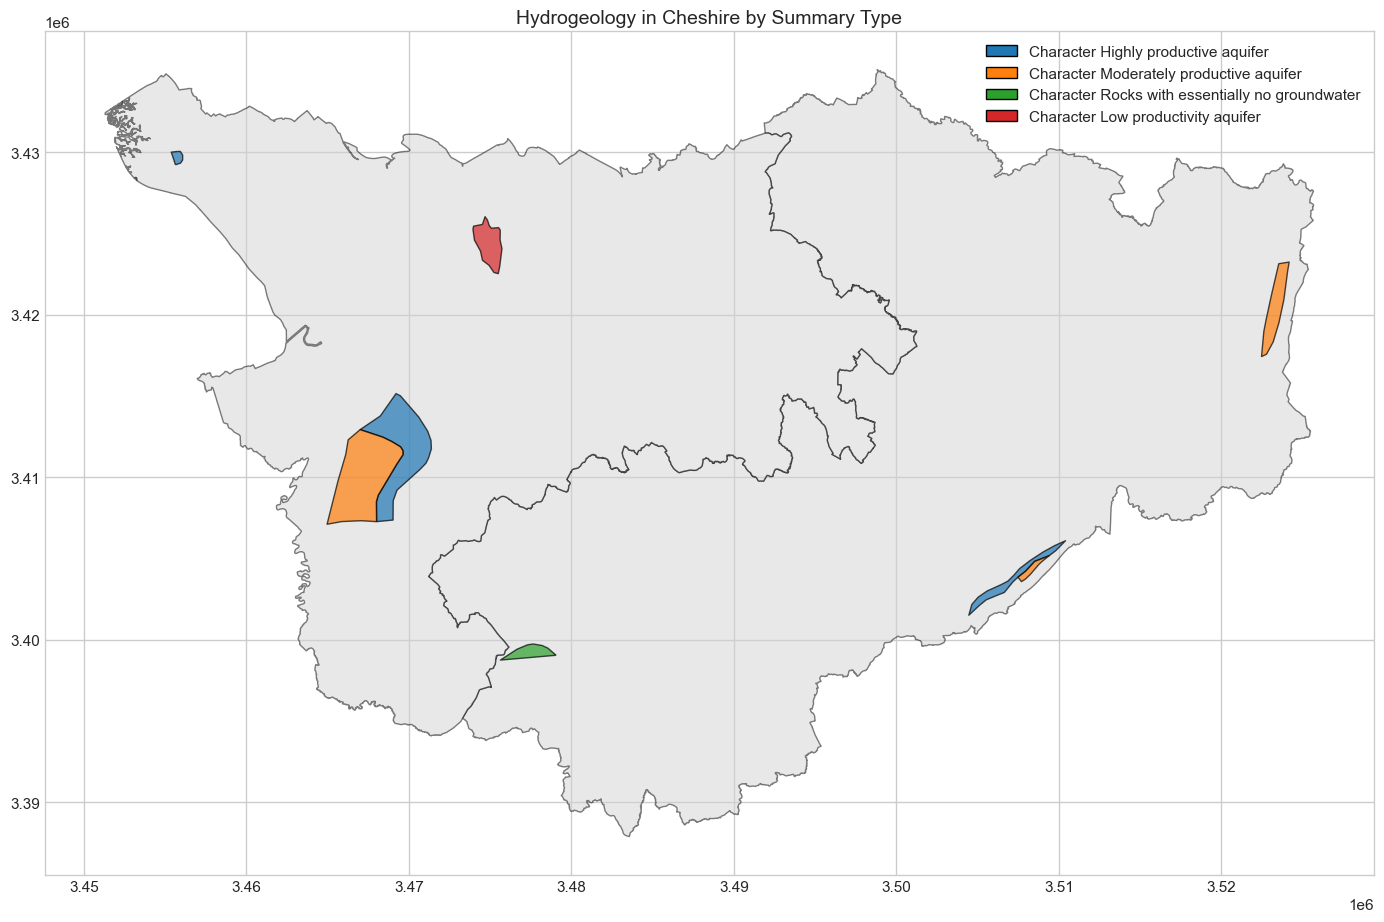

In [48]:

fig, ax = plt.subplots(figsize=(10, 10))
cheshire.plot(ax=ax, color='white', edgecolor='black', aspect='equal')
gwdf_filtered = gwdf[gwdf.geometry.within(cheshire.unary_union)]
gwdf_filtered.plot(ax=ax, color='blue', linewidth=2)
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Hydrogeology Map')]
ax.legend(handles=legend_elements)
plt.title("Hydrogeology Map")
plt.show()

grouped_by = gwdf_filtered.groupby('CHARACTER')
unique_characters = gwdf_filtered['CHARACTER'].unique() 
print(f"Number of unique CHARACTER values: {len(unique_characters)}")

fig, ax = plt.subplots(figsize=(14, 10))
cheshire.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

colors = list(mcolors.TABLEAU_COLORS.values())

legend_elements = []
for i, char_value in enumerate(unique_characters):
    # Select only records with this CHARACTER
    char_data = gwdf_filtered[gwdf_filtered['CHARACTER'] == char_value] # 변경: 'CLASS' -> 'CHARACTER'

    # Plot this CHARACTER with a specific color
    color = colors[i % len(colors)]
    char_data.plot(ax=ax, color=color, edgecolor='black', alpha=0.7)

    # Create a legend entry for this CHARACTER
    legend_elements.append(Patch(facecolor=color, edgecolor='black',
                                label=f'Character {char_value}')) # 변경: 'Class' -> 'Character'

# Add the legend with our manually created elements
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Hydrogeology in Cheshire by Summary Type", fontsize=14)
plt.tight_layout()

plt.savefig('Hydrogeology.png')

plt.show()